# 付録A4: 六次の隔たり（スモールワールド現象）

## 学習目標
- 六次の隔たり（Six Degrees of Separation）の概念を理解する
- スモールワールド現象の数学的背景を学ぶ
- Watts-Strogatzモデルでスモールワールドネットワークを生成する
- 平均経路長とクラスタリング係数の関係を分析する

## 難易度: 中級

---
## A4.1 六次の隔たりとは？

**六次の隔たり（Six Degrees of Separation）** は、「世界中の任意の2人は、平均して6人の知り合いの連鎖で繋がっている」という仮説です。

### 歴史的背景

| 年 | 出来事 |
|------|--------|
| 1929 | ハンガリーの作家カリンティ・フリジェシュが短編小説で「5人の連鎖」を提唱 |
| 1967 | 社会心理学者スタンレー・ミルグラムが「スモールワールド実験」を実施 |
| 1998 | ワッツとストロガッツがスモールワールドネットワークの数学モデルを発表 |
| 2011 | Facebookの研究で平均4.74人の隔たりと判明 |

### ミルグラムの実験

1967年、ミルグラムは以下の実験を行いました：

1. ネブラスカ州とカンザス州の住民に手紙を送る
2. 「ボストンの特定の株式仲買人に届けてください」と依頼
3. 直接知らない場合は、知っていそうな知人に転送
4. 届いた手紙の平均転送回数を計測

結果：**平均約6回の転送**で届いた → 「六次の隔たり」の起源

---
## A4.2 環境のセットアップ

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.rcParams['font.sans-serif'] = ['IPAexGothic'] + plt.rcParams['font.sans-serif']
%matplotlib inline

print(f"NetworkX version: {nx.__version__}")
print(f"NumPy version: {np.__version__}")

NetworkX version: 3.6.1
NumPy version: 2.3.5


---
## A4.3 なぜ「6」なのか？ - 直感的理解

まず、単純な計算で「6」という数字の妥当性を確認しましょう。

In [2]:
# 仮定：各人が平均44人の知り合いを持つ
avg_friends = 44

print("知り合いの連鎖で到達できる人数（理論上限）")
print("=" * 50)

reachable = 1
for step in range(1, 8):
    reachable *= avg_friends
    print(f"{step}次の隔たり: {reachable:,}人")
    if reachable > 8_000_000_000:
        print(f"  → 世界人口（約80億人）を超過！")
        break

print(f"\n平均{avg_friends}人の知り合いがいれば、6次で世界中の誰とでも繋がれる可能性がある")

知り合いの連鎖で到達できる人数（理論上限）
1次の隔たり: 44人
2次の隔たり: 1,936人
3次の隔たり: 85,184人
4次の隔たり: 3,748,096人
5次の隔たり: 164,916,224人
6次の隔たり: 7,256,313,856人
7次の隔たり: 319,277,809,664人
  → 世界人口（約80億人）を超過！

平均44人の知り合いがいれば、6次で世界中の誰とでも繋がれる可能性がある


### 注意点

上の計算は単純化されています。実際には：
- 知り合いの知り合いは重複する（友達の友達が同じ）
- 社会は完全にランダムではない（地域・職業などでクラスター化）
- 一部の人は非常に多くの知り合いを持つ（ハブの存在）

これらを考慮したのが **スモールワールドネットワーク** モデルです。

---
## A4.4 ステップ1: 基本的な経路長の計算

NetworkXを使って、グラフ内の最短経路長を計算する方法を学びます。

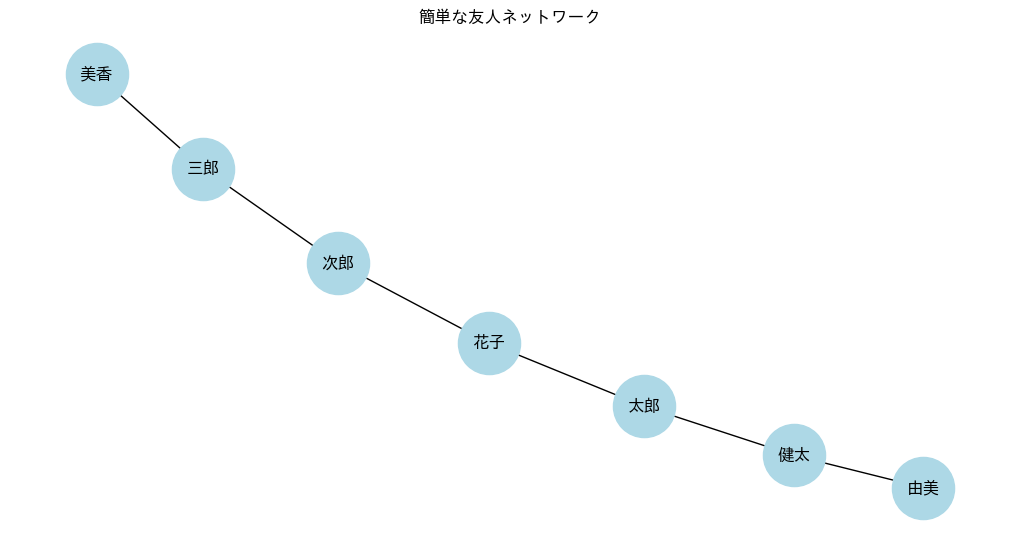

In [3]:
# 簡単な例: 小さなグラフで経路長を確認
G_simple = nx.Graph()
G_simple.add_edges_from([
    ("太郎", "花子"), ("花子", "次郎"), ("次郎", "三郎"),
    ("三郎", "美香"), ("太郎", "健太"), ("健太", "由美")
])

# 可視化
plt.figure(figsize=(10, 5))
pos = nx.spring_layout(G_simple, seed=42)
nx.draw(G_simple, pos, with_labels=True, node_color='lightblue',
        node_size=2000, font_size=12, font_weight='bold')
plt.title("簡単な友人ネットワーク")
plt.show()

In [4]:
# 特定の2人間の最短経路
path = nx.shortest_path(G_simple, "太郎", "美香")
length = nx.shortest_path_length(G_simple, "太郎", "美香")

print(f"太郎から美香への最短経路: {' → '.join(path)}")
print(f"経路長（隔たり）: {length}")

太郎から美香への最短経路: 太郎 → 花子 → 次郎 → 三郎 → 美香
経路長（隔たり）: 4


In [5]:
# 全ペア間の最短経路長
print("全ペア間の最短経路長")
print("=" * 50)

all_pairs = dict(nx.all_pairs_shortest_path_length(G_simple))

for source in G_simple.nodes():
    for target in G_simple.nodes():
        if source < target:  # 重複を避ける
            length = all_pairs[source][target]
            print(f"{source} ↔ {target}: {length}")

全ペア間の最短経路長
太郎 ↔ 花子: 1
太郎 ↔ 次郎: 2
太郎 ↔ 美香: 4
太郎 ↔ 由美: 2
次郎 ↔ 花子: 1
次郎 ↔ 美香: 2
次郎 ↔ 由美: 4
三郎 ↔ 太郎: 3
三郎 ↔ 花子: 2
三郎 ↔ 次郎: 1
三郎 ↔ 美香: 1
三郎 ↔ 健太: 4
三郎 ↔ 由美: 5
美香 ↔ 花子: 3
健太 ↔ 太郎: 1
健太 ↔ 花子: 2
健太 ↔ 次郎: 3
健太 ↔ 美香: 5
健太 ↔ 由美: 1
由美 ↔ 花子: 3
由美 ↔ 美香: 6


In [6]:
# 平均経路長の計算
avg_path_length = nx.average_shortest_path_length(G_simple)
print(f"\n平均経路長: {avg_path_length:.3f}")


平均経路長: 2.667


---
## A4.5 ステップ2: 規則的ネットワーク vs ランダムネットワーク

スモールワールドを理解するため、2つの極端なネットワークを比較します。

In [7]:
n = 100  # ノード数
k = 6    # 各ノードの隣接数（偶数）

# 1. 規則的なリングネットワーク（lattice）
# 各ノードが両隣k/2人ずつと接続
G_regular = nx.watts_strogatz_graph(n, k, p=0)  # p=0で再配線なし

# 2. 完全ランダムネットワーク
G_random = nx.watts_strogatz_graph(n, k, p=1)   # p=1で完全ランダム化

# 特性を計算
def network_stats(G, name):
    avg_path = nx.average_shortest_path_length(G)
    clustering = nx.average_clustering(G)
    return {
        "name": name,
        "avg_path_length": avg_path,
        "clustering": clustering
    }

stats_regular = network_stats(G_regular, "規則的（リング）")
stats_random = network_stats(G_random, "ランダム")

print("ネットワーク特性の比較")
print("=" * 60)
print(f"{'タイプ':<20} {'平均経路長':>15} {'クラスタリング係数':>20}")
print("-" * 60)
for s in [stats_regular, stats_random]:
    print(f"{s['name']:<20} {s['avg_path_length']:>15.3f} {s['clustering']:>20.3f}")

ネットワーク特性の比較
タイプ                            平均経路長            クラスタリング係数
------------------------------------------------------------
規則的（リング）                       8.758                0.600
ランダム                           2.709                0.043


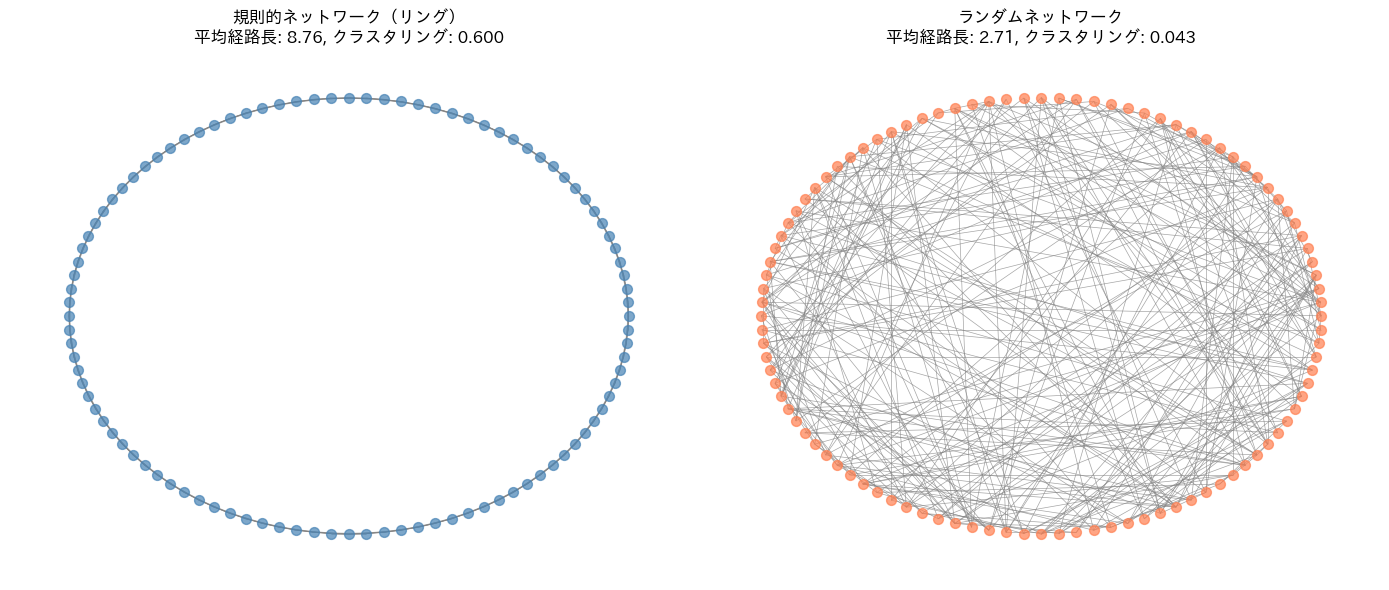

In [8]:
# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 規則的ネットワーク
ax1 = axes[0]
pos_regular = nx.circular_layout(G_regular)
nx.draw(G_regular, pos_regular, ax=ax1, node_size=50, node_color='steelblue',
        edge_color='gray', alpha=0.7, width=0.5)
ax1.set_title(f"規則的ネットワーク（リング）\n平均経路長: {stats_regular['avg_path_length']:.2f}, "
              f"クラスタリング: {stats_regular['clustering']:.3f}")

# ランダムネットワーク
ax2 = axes[1]
pos_random = nx.circular_layout(G_random)
nx.draw(G_random, pos_random, ax=ax2, node_size=50, node_color='coral',
        edge_color='gray', alpha=0.7, width=0.5)
ax2.set_title(f"ランダムネットワーク\n平均経路長: {stats_random['avg_path_length']:.2f}, "
              f"クラスタリング: {stats_random['clustering']:.3f}")

plt.tight_layout()
plt.show()

### 2つのネットワークの特徴

| 特性 | 規則的（リング） | ランダム |
|------|-----------------|----------|
| 平均経路長 | **長い**（対角のノードまで遠い） | **短い**（ショートカットが多い） |
| クラスタリング | **高い**（隣同士は共通の友人が多い） | **低い**（友達の友達が友達とは限らない） |

**問題**: 現実の社会ネットワークは、どちらにも当てはまらない
- 経路長は短い（六次の隔たり）✓ ランダム的
- クラスタリングは高い（友達の友達は友達）✓ 規則的

---
## A4.6 ステップ3: Watts-Strogatzモデル（スモールワールド）

1998年、ワッツとストロガッツは「規則的でもランダムでもない」中間的なネットワークモデルを提案しました。

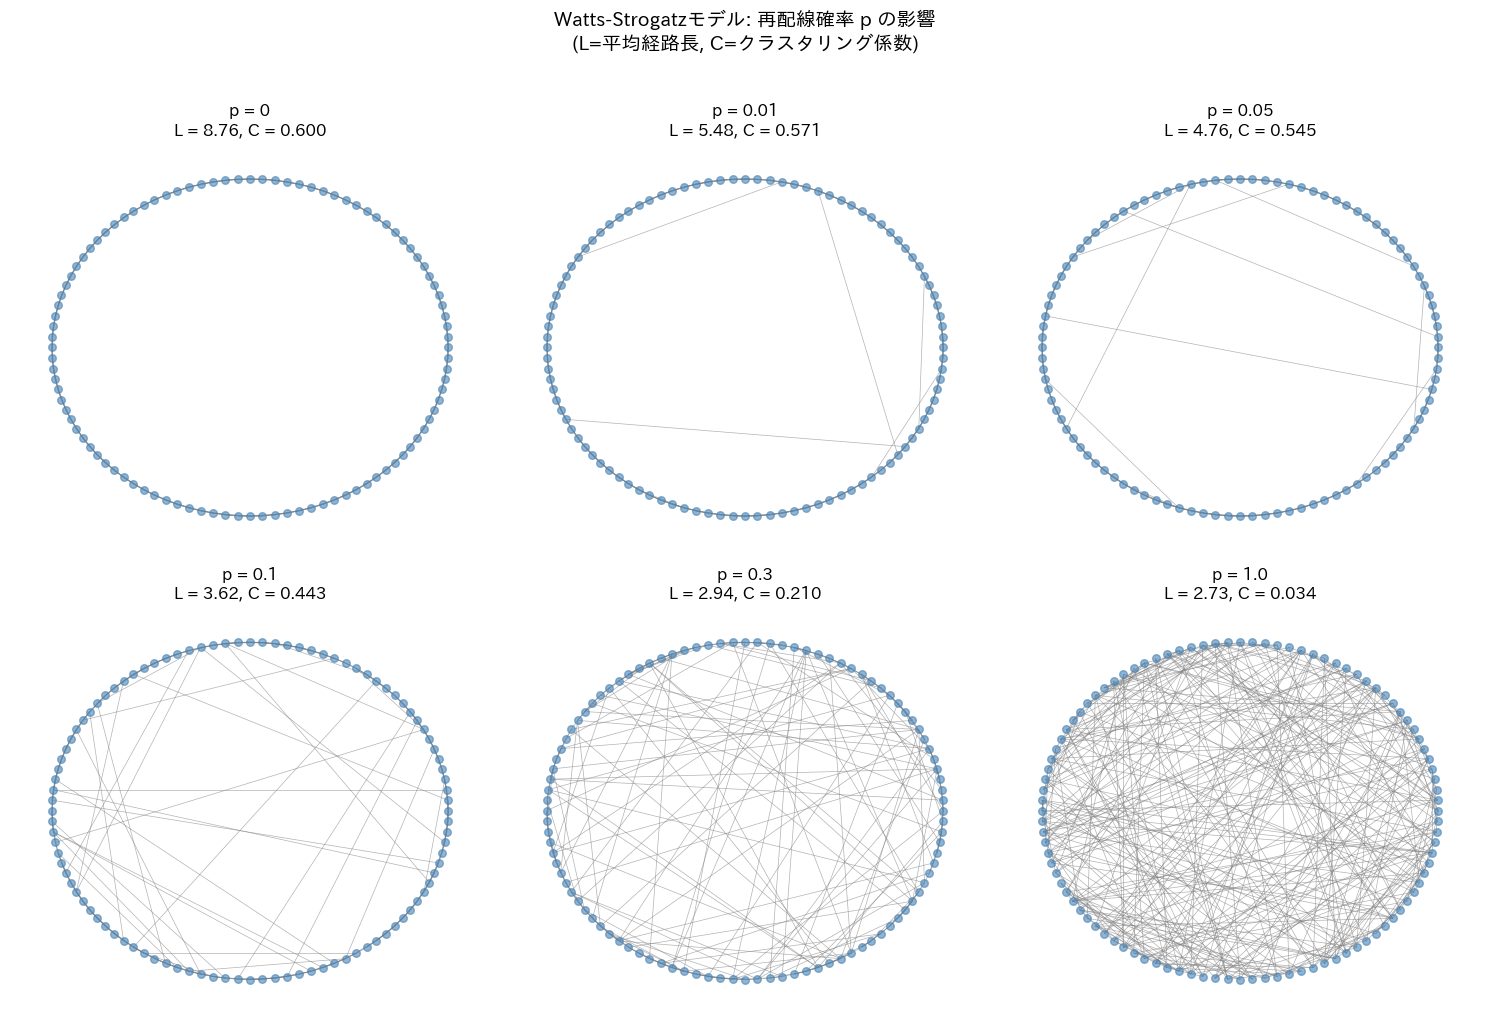

In [9]:
# Watts-Strogatzモデルの生成
# p: 再配線確率（0=規則的、1=ランダム）

n = 100
k = 6

# 異なる再配線確率でネットワークを生成
p_values = [0, 0.01, 0.05, 0.1, 0.3, 1.0]
ws_networks = {}

for p in p_values:
    G = nx.watts_strogatz_graph(n, k, p, seed=42)
    ws_networks[p] = G

# 可視化
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, p in zip(axes, p_values):
    G = ws_networks[p]
    pos = nx.circular_layout(G)
    
    avg_path = nx.average_shortest_path_length(G)
    clustering = nx.average_clustering(G)
    
    nx.draw(G, pos, ax=ax, node_size=30, node_color='steelblue',
            edge_color='gray', alpha=0.6, width=0.5)
    ax.set_title(f"p = {p}\nL = {avg_path:.2f}, C = {clustering:.3f}")

plt.suptitle("Watts-Strogatzモデル: 再配線確率 p の影響\n(L=平均経路長, C=クラスタリング係数)", 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### スモールワールド現象の発見

p=0.01〜0.1 の範囲で「スモールワールド」が出現：
- 平均経路長が急激に短くなる（少数のショートカットで十分）
- クラスタリング係数はまだ高いまま

これが現実の社会ネットワークの特性に近い！

In [10]:
# より詳細な分析: pを連続的に変化させる
n = 500
k = 10

p_range = np.logspace(-4, 0, 30)  # 0.0001 から 1 まで対数スケール

# 正規化のための基準値
G_regular = nx.watts_strogatz_graph(n, k, 0, seed=42)
L0 = nx.average_shortest_path_length(G_regular)
C0 = nx.average_clustering(G_regular)

results = []
for p in p_range:
    G = nx.watts_strogatz_graph(n, k, p, seed=42)
    L = nx.average_shortest_path_length(G)
    C = nx.average_clustering(G)
    results.append({
        'p': p,
        'L': L,
        'C': C,
        'L_normalized': L / L0,
        'C_normalized': C / C0
    })

print(f"基準値（p=0）: L0 = {L0:.2f}, C0 = {C0:.3f}")

基準値（p=0）: L0 = 25.45, C0 = 0.667


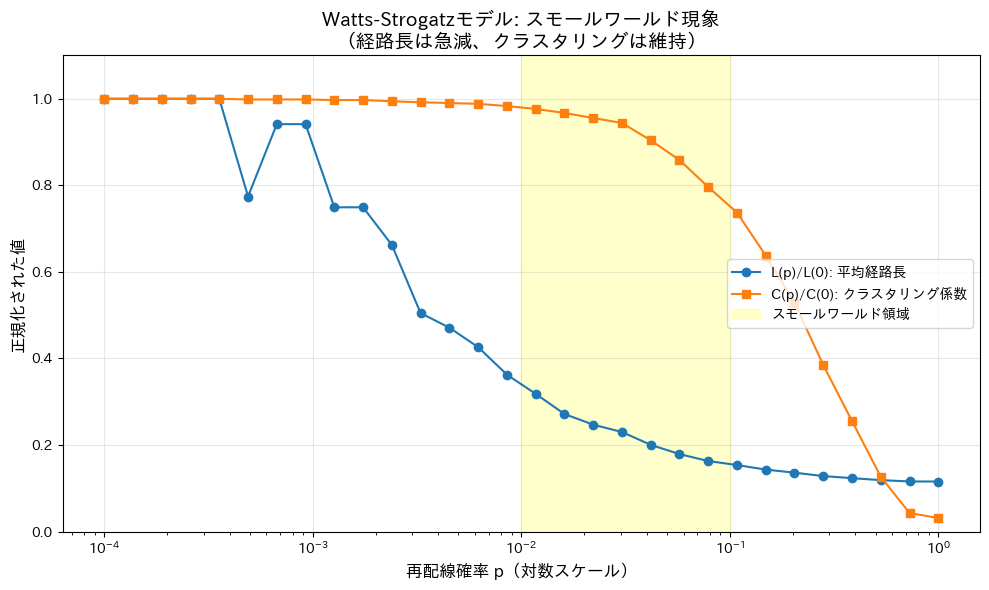

In [11]:
# ワッツ・ストロガッツの有名なグラフを再現
plt.figure(figsize=(10, 6))

p_vals = [r['p'] for r in results]
L_norm = [r['L_normalized'] for r in results]
C_norm = [r['C_normalized'] for r in results]

plt.semilogx(p_vals, L_norm, 'o-', label='L(p)/L(0): 平均経路長', markersize=6)
plt.semilogx(p_vals, C_norm, 's-', label='C(p)/C(0): クラスタリング係数', markersize=6)

# スモールワールド領域をハイライト
plt.axvspan(0.01, 0.1, alpha=0.2, color='yellow', label='スモールワールド領域')

plt.xlabel('再配線確率 p（対数スケール）', fontsize=12)
plt.ylabel('正規化された値', fontsize=12)
plt.title('Watts-Strogatzモデル: スモールワールド現象\n（経路長は急減、クラスタリングは維持）', fontsize=14)
plt.legend(loc='center right')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

### グラフの解釈

**スモールワールド領域（p ≈ 0.01〜0.1）**:
- 平均経路長 L(p)/L(0) が急激に減少（0.2〜0.3程度に）
- クラスタリング係数 C(p)/C(0) はまだ高いまま（0.7〜0.9程度）

**なぜこうなるか？**
- 少数のランダムなショートカットが、遠くのノード同士を結ぶ
- 局所的な構造（三角形）はほとんど壊れない

これが「六次の隔たり」の数学的説明です！

---
## A4.7 ステップ4: 大規模ネットワークでのシミュレーション

より現実的な規模でシミュレーションを行い、「6」という数字を検証します。

In [12]:
# 異なるモデルで大規模ネットワークを生成
n = 10000  # 1万人

print("大規模ネットワークの生成と分析")
print("=" * 60)

networks = {}

# 1. Watts-Strogatz（スモールワールド）
print("Watts-Strogatzモデルを生成中...")
G_ws = nx.watts_strogatz_graph(n, k=20, p=0.05, seed=42)
networks["Watts-Strogatz"] = G_ws

# 2. Barabási-Albert（スケールフリー）
print("Barabási-Albertモデルを生成中...")
G_ba = nx.barabasi_albert_graph(n, m=10, seed=42)
networks["Barabási-Albert"] = G_ba

# 3. Erdős-Rényi（ランダム）
print("Erdős-Rényiモデルを生成中...")
p_er = 20 / (n - 1)  # 平均次数が約20になるように
G_er = nx.erdos_renyi_graph(n, p_er, seed=42)
# 最大連結成分のみ使用
if not nx.is_connected(G_er):
    G_er = G_er.subgraph(max(nx.connected_components(G_er), key=len)).copy()
networks["Erdős-Rényi"] = G_er

print("\n分析結果:")
print("-" * 60)

大規模ネットワークの生成と分析
Watts-Strogatzモデルを生成中...
Barabási-Albertモデルを生成中...


Erdős-Rényiモデルを生成中...



分析結果:
------------------------------------------------------------


In [13]:
# 各ネットワークの統計を計算
results_large = {}

for name, G in networks.items():
    print(f"\n{name}の分析中...")
    
    # 基本統計
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    avg_degree = 2 * n_edges / n_nodes
    
    # 平均経路長（サンプリングで近似）
    # 全ペアは計算コストが高いので、サンプリング
    sample_size = 1000
    nodes = list(G.nodes())
    np.random.seed(42)
    sample_nodes = np.random.choice(nodes, size=min(sample_size, len(nodes)), replace=False)
    
    path_lengths = []
    for source in sample_nodes:
        lengths = nx.single_source_shortest_path_length(G, source)
        path_lengths.extend(lengths.values())
    avg_path = np.mean(path_lengths)
    max_path = max(path_lengths)
    
    # クラスタリング係数
    clustering = nx.average_clustering(G)
    
    results_large[name] = {
        'nodes': n_nodes,
        'edges': n_edges,
        'avg_degree': avg_degree,
        'avg_path': avg_path,
        'max_path': max_path,
        'clustering': clustering
    }
    
    print(f"  ノード数: {n_nodes:,}")
    print(f"  エッジ数: {n_edges:,}")
    print(f"  平均次数: {avg_degree:.1f}")
    print(f"  平均経路長: {avg_path:.2f}")
    print(f"  最大経路長: {max_path}")
    print(f"  クラスタリング係数: {clustering:.4f}")


Watts-Strogatzの分析中...


  ノード数: 10,000
  エッジ数: 100,000
  平均次数: 20.0
  平均経路長: 4.99
  最大経路長: 7
  クラスタリング係数: 0.6113

Barabási-Albertの分析中...


  ノード数: 10,000
  エッジ数: 99,900
  平均次数: 20.0
  平均経路長: 3.05
  最大経路長: 5
  クラスタリング係数: 0.0113

Erdős-Rényiの分析中...


  ノード数: 10,000
  エッジ数: 99,803
  平均次数: 20.0
  平均経路長: 3.41
  最大経路長: 5
  クラスタリング係数: 0.0020


In [14]:
# 結果を表形式で比較
print("\n" + "=" * 80)
print("ネットワークモデル比較（n ≈ 10,000）")
print("=" * 80)
print(f"{'モデル':<20} {'平均次数':>10} {'平均経路長':>12} {'最大経路長':>10} {'クラスタリング':>15}")
print("-" * 80)

for name, r in results_large.items():
    print(f"{name:<20} {r['avg_degree']:>10.1f} {r['avg_path']:>12.2f} "
          f"{r['max_path']:>10} {r['clustering']:>15.4f}")


ネットワークモデル比較（n ≈ 10,000）
モデル                        平均次数        平均経路長      最大経路長         クラスタリング
--------------------------------------------------------------------------------
Watts-Strogatz             20.0         4.99          7          0.6113
Barabási-Albert            20.0         3.05          5          0.0113
Erdős-Rényi                20.0         3.41          5          0.0020


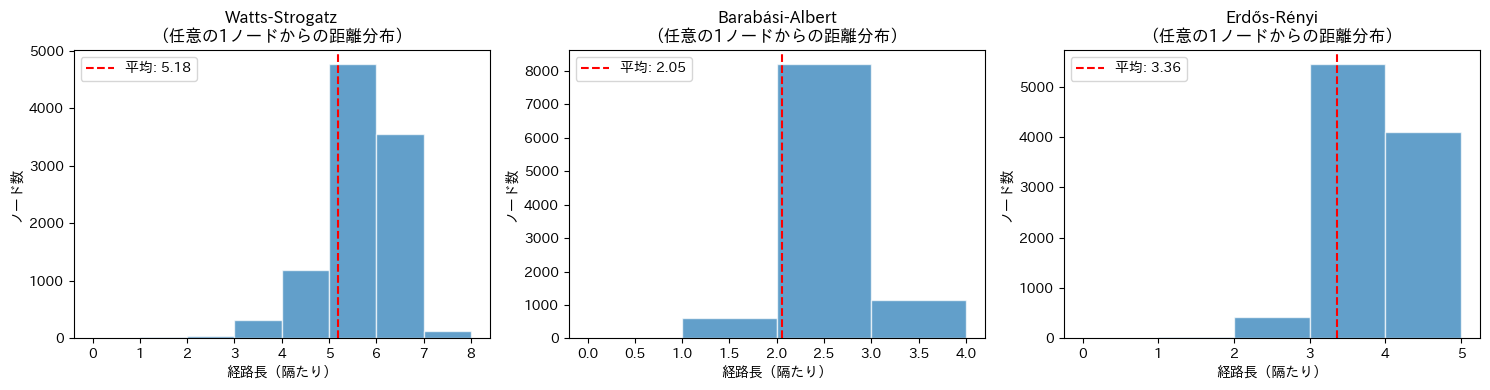

In [15]:
# 経路長の分布を可視化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, G) in zip(axes, networks.items()):
    # サンプルノードからの経路長を計算
    sample_node = list(G.nodes())[0]
    lengths = dict(nx.single_source_shortest_path_length(G, sample_node))
    
    # ヒストグラム
    ax.hist(list(lengths.values()), bins=range(max(lengths.values())+2), 
            edgecolor='white', alpha=0.7)
    ax.axvline(np.mean(list(lengths.values())), color='red', linestyle='--',
               label=f'平均: {np.mean(list(lengths.values())):.2f}')
    ax.set_xlabel('経路長（隔たり）')
    ax.set_ylabel('ノード数')
    ax.set_title(f'{name}\n（任意の1ノードからの距離分布）')
    ax.legend()

plt.tight_layout()
plt.show()

### 結果の考察

10,000ノード、平均次数約20のネットワークで：
- **平均経路長は約3〜4** → 1万人でこの短さ！
- 世界の80億人だと、対数的に増えるので約6になる

**経路長の増加は対数的**: $L \propto \log(N) / \log(k)$

つまり、人数が1000倍になっても経路長は2〜3しか増えない。

---
## A4.8 ステップ5: 実際のSNSデータに近いシミュレーション

In [16]:
# Facebook研究（2011年）のパラメータに近づける
# 当時のFacebook: 約7.2億ユーザー、平均友達数190人

# 計算可能な規模でシミュレート
n = 50000  # 5万人
avg_friends = 50  # 平均友達数（計算効率のため小さめ）

print(f"SNS風ネットワークのシミュレーション")
print(f"  ノード数: {n:,}")
print(f"  平均友達数: {avg_friends}")
print("\n生成中...")

# スケールフリー + クラスタリングを持つモデル
G_sns = nx.powerlaw_cluster_graph(n=n, m=avg_friends//2, p=0.5, seed=42)

print("分析中...")

SNS風ネットワークのシミュレーション
  ノード数: 50,000
  平均友達数: 50

生成中...


分析中...


In [17]:
# 統計計算
actual_avg_degree = 2 * G_sns.number_of_edges() / G_sns.number_of_nodes()
clustering = nx.average_clustering(G_sns)

# 経路長（サンプリング）
nodes = list(G_sns.nodes())
np.random.seed(42)
sample = np.random.choice(nodes, size=500, replace=False)

all_lengths = []
for source in sample:
    lengths = nx.single_source_shortest_path_length(G_sns, source)
    all_lengths.extend(lengths.values())

avg_path = np.mean(all_lengths)
max_path = max(all_lengths)

print(f"\nSNS風ネットワークの統計")
print("=" * 50)
print(f"ノード数: {G_sns.number_of_nodes():,}")
print(f"エッジ数: {G_sns.number_of_edges():,}")
print(f"平均次数（友達数）: {actual_avg_degree:.1f}")
print(f"クラスタリング係数: {clustering:.4f}")
print(f"平均経路長: {avg_path:.2f}")
print(f"最大経路長: {max_path}")

# 理論的な予測
theoretical_path = np.log(n) / np.log(actual_avg_degree)
print(f"\n理論的な経路長（log(N)/log(k)）: {theoretical_path:.2f}")


SNS風ネットワークの統計
ノード数: 50,000
エッジ数: 1,248,104
平均次数（友達数）: 49.9
クラスタリング係数: 0.0491
平均経路長: 2.80
最大経路長: 4

理論的な経路長（log(N)/log(k)）: 2.77


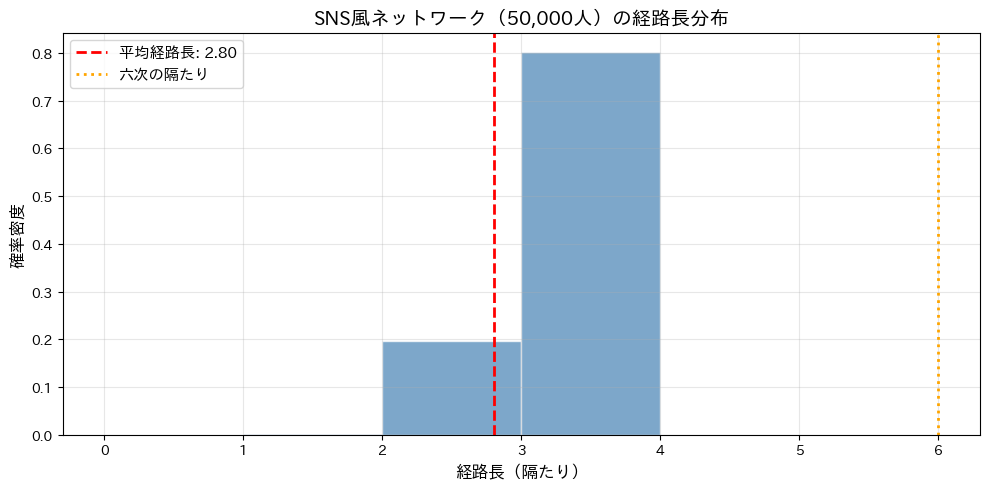

/tmp/ipykernel_2744/2767357883.py:39: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


/home/katzkawai/networkx-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


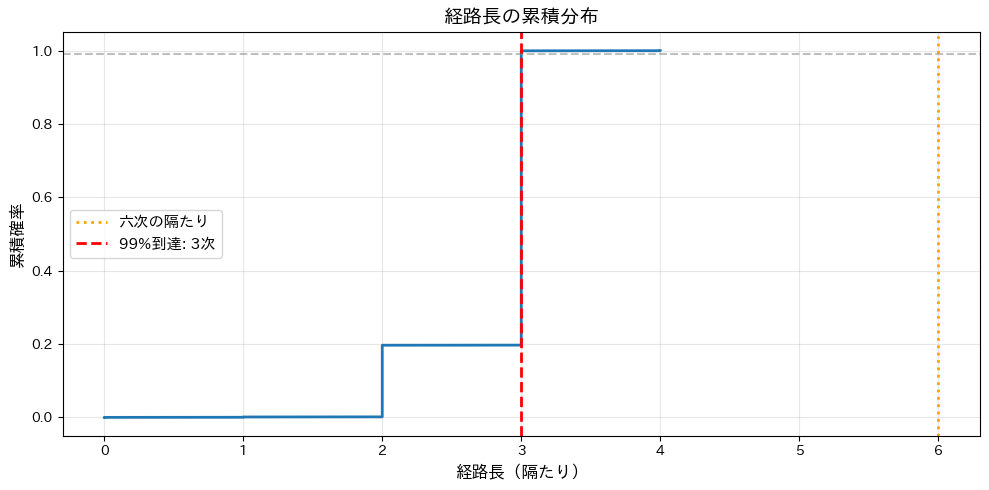

In [18]:
# 経路長の分布
plt.figure(figsize=(10, 5))

# ヒストグラム
plt.hist(all_lengths, bins=range(max(all_lengths)+2), density=True,
         edgecolor='white', alpha=0.7, color='steelblue')
plt.axvline(avg_path, color='red', linestyle='--', linewidth=2,
            label=f'平均経路長: {avg_path:.2f}')
plt.axvline(6, color='orange', linestyle=':', linewidth=2,
            label='六次の隔たり')

plt.xlabel('経路長（隔たり）', fontsize=12)
plt.ylabel('確率密度', fontsize=12)
plt.title(f'SNS風ネットワーク（{n:,}人）の経路長分布', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 累積分布
plt.figure(figsize=(10, 5))
sorted_lengths = np.sort(all_lengths)
cumulative = np.arange(1, len(sorted_lengths)+1) / len(sorted_lengths)

plt.plot(sorted_lengths, cumulative, linewidth=2)
plt.axhline(0.99, color='gray', linestyle='--', alpha=0.5)
plt.axvline(6, color='orange', linestyle=':', linewidth=2, label='六次の隔たり')

# 99%が到達できる経路長
path_99 = sorted_lengths[int(len(sorted_lengths) * 0.99)]
plt.axvline(path_99, color='red', linestyle='--', linewidth=2,
            label=f'99%到達: {path_99}次')

plt.xlabel('経路長（隔たり）', fontsize=12)
plt.ylabel('累積確率', fontsize=12)
plt.title('経路長の累積分布', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## A4.9 スケール効果: ネットワークサイズと経路長

ノード数が増えると経路長はどう変化するか確認します。

In [19]:
# 異なるサイズでの経路長を測定
sizes = [100, 500, 1000, 5000, 10000, 30000]
k = 20  # 平均次数を固定

scaling_results = []

print("スケーリング分析")
print("=" * 50)

for n in sizes:
    print(f"n = {n:,} を分析中...")
    
    # スモールワールドネットワーク
    G = nx.watts_strogatz_graph(n, k, p=0.05, seed=42)
    
    # サンプリングで経路長を推定
    nodes = list(G.nodes())
    sample = np.random.choice(nodes, size=min(200, n), replace=False)
    
    lengths = []
    for source in sample:
        l = nx.single_source_shortest_path_length(G, source)
        lengths.extend(l.values())
    
    scaling_results.append({
        'n': n,
        'avg_path': np.mean(lengths),
        'log_n': np.log(n)
    })

print("完了！")

スケーリング分析
n = 100 を分析中...
n = 500 を分析中...
n = 1,000 を分析中...
n = 5,000 を分析中...


n = 10,000 を分析中...


n = 30,000 を分析中...


完了！


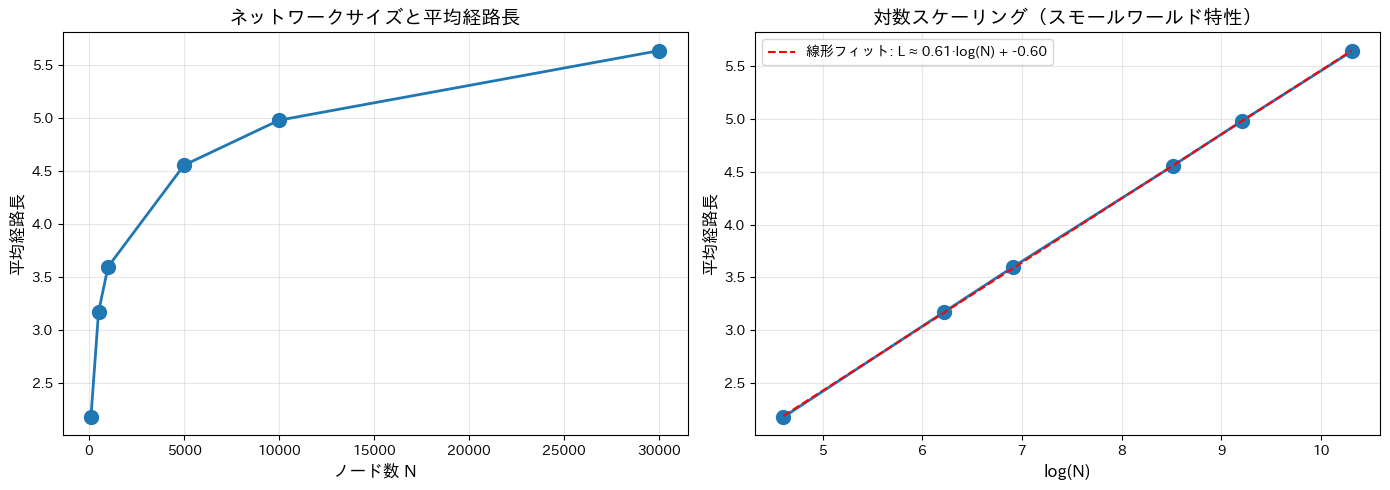


世界人口（80億人）での予測経路長: 13.2


In [20]:
# 結果をプロット
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ns = [r['n'] for r in scaling_results]
paths = [r['avg_path'] for r in scaling_results]
log_ns = [r['log_n'] for r in scaling_results]

# 左: 線形スケール
ax1 = axes[0]
ax1.plot(ns, paths, 'o-', markersize=10, linewidth=2)
ax1.set_xlabel('ノード数 N', fontsize=12)
ax1.set_ylabel('平均経路長', fontsize=12)
ax1.set_title('ネットワークサイズと平均経路長', fontsize=14)
ax1.grid(True, alpha=0.3)

# 右: log(N) vs 経路長
ax2 = axes[1]
ax2.plot(log_ns, paths, 'o-', markersize=10, linewidth=2)

# 線形フィット
z = np.polyfit(log_ns, paths, 1)
p_fit = np.poly1d(z)
ax2.plot(log_ns, p_fit(log_ns), '--', color='red', 
         label=f'線形フィット: L ≈ {z[0]:.2f}·log(N) + {z[1]:.2f}')

ax2.set_xlabel('log(N)', fontsize=12)
ax2.set_ylabel('平均経路長', fontsize=12)
ax2.set_title('対数スケーリング（スモールワールド特性）', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 世界人口（80億人）での予測
log_world = np.log(8e9)
predicted_world = p_fit(log_world)
print(f"\n世界人口（80億人）での予測経路長: {predicted_world:.1f}")

---
## 練習問題

### 練習問題1: 再配線確率の影響

Watts-Strogatzモデルで、ノード数 n=1000、次数 k=10 として、再配線確率 p を 0.001, 0.01, 0.1, 0.5 と変化させたときの平均経路長とクラスタリング係数を計算し、グラフにプロットしてください。

In [21]:
# ここにコードを記述してください


<details>
<summary>解答を見る</summary>

```python
n = 1000
k = 10
p_values = [0.001, 0.01, 0.1, 0.5]

results = []
for p in p_values:
    G = nx.watts_strogatz_graph(n, k, p, seed=42)
    avg_path = nx.average_shortest_path_length(G)
    clustering = nx.average_clustering(G)
    results.append({'p': p, 'L': avg_path, 'C': clustering})
    print(f"p={p}: 平均経路長={avg_path:.3f}, クラスタリング={clustering:.3f}")

# プロット
fig, ax1 = plt.subplots(figsize=(10, 5))

ps = [r['p'] for r in results]
Ls = [r['L'] for r in results]
Cs = [r['C'] for r in results]

ax1.semilogx(ps, Ls, 'o-', color='blue', label='平均経路長 L')
ax1.set_xlabel('再配線確率 p')
ax1.set_ylabel('平均経路長 L', color='blue')

ax2 = ax1.twinx()
ax2.semilogx(ps, Cs, 's-', color='red', label='クラスタリング C')
ax2.set_ylabel('クラスタリング係数 C', color='red')

plt.title('Watts-Strogatzモデルのパラメータ依存性')
plt.show()
```
</details>

### 練習問題2: 特定のノード間の経路探索

1000ノードのWatts-Strogatzグラフ（k=6, p=0.1）を生成し、ノード0からノード500への最短経路を見つけ、その経路を可視化してください。

In [22]:
# ここにコードを記述してください


<details>
<summary>解答を見る</summary>

```python
# グラフ生成
G = nx.watts_strogatz_graph(1000, 6, 0.1, seed=42)

# 最短経路
path = nx.shortest_path(G, 0, 500)
print(f"最短経路: {path}")
print(f"経路長: {len(path) - 1}")

# 可視化（経路に関連するノードのみ）
# 経路上のノードとその隣接ノードを抽出
nodes_to_show = set(path)
for node in path:
    nodes_to_show.update(G.neighbors(node))

subgraph = G.subgraph(nodes_to_show)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)

# 背景のエッジ
nx.draw_networkx_edges(subgraph, pos, alpha=0.2)

# 経路のエッジをハイライト
path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
nx.draw_networkx_edges(subgraph, pos, edgelist=path_edges, 
                       edge_color='red', width=3)

# ノード
colors = ['red' if n in path else 'lightblue' for n in subgraph.nodes()]
sizes = [500 if n in path else 100 for n in subgraph.nodes()]
nx.draw_networkx_nodes(subgraph, pos, node_color=colors, node_size=sizes)

# 経路上のノードにラベル
labels = {n: str(n) for n in path}
nx.draw_networkx_labels(subgraph, pos, labels, font_size=10)

plt.title(f"ノード0からノード500への最短経路（長さ: {len(path)-1}）")
plt.axis('off')
plt.tight_layout()
plt.show()
```
</details>

### 練習問題3: モデル比較

同じノード数（n=5000）と平均次数（約10）を持つ以下の3種類のネットワークを生成し、平均経路長とクラスタリング係数を比較してください：
1. Erdős-Rényi（ランダム）
2. Watts-Strogatz（p=0.1）
3. Barabási-Albert（スケールフリー）

In [23]:
# ここにコードを記述してください


<details>
<summary>解答を見る</summary>

```python
n = 5000
target_degree = 10

# 各モデルを生成
G_er = nx.erdos_renyi_graph(n, target_degree/(n-1), seed=42)
G_ws = nx.watts_strogatz_graph(n, target_degree, 0.1, seed=42)
G_ba = nx.barabasi_albert_graph(n, target_degree//2, seed=42)

# 連結成分のみ使用
if not nx.is_connected(G_er):
    G_er = G_er.subgraph(max(nx.connected_components(G_er), key=len)).copy()

models = {
    'Erdős-Rényi': G_er,
    'Watts-Strogatz': G_ws,
    'Barabási-Albert': G_ba
}

# 分析
print("モデル比較（n ≈ 5000、平均次数 ≈ 10）")
print("=" * 60)

results = []
for name, G in models.items():
    # サンプリングで経路長を推定
    nodes = list(G.nodes())
    sample = np.random.choice(nodes, size=200, replace=False)
    lengths = []
    for s in sample:
        lengths.extend(nx.single_source_shortest_path_length(G, s).values())
    
    avg_degree = 2 * G.number_of_edges() / G.number_of_nodes()
    avg_path = np.mean(lengths)
    clustering = nx.average_clustering(G)
    
    results.append({
        'name': name,
        'avg_degree': avg_degree,
        'avg_path': avg_path,
        'clustering': clustering
    })
    
    print(f"{name}:")
    print(f"  平均次数: {avg_degree:.1f}")
    print(f"  平均経路長: {avg_path:.2f}")
    print(f"  クラスタリング: {clustering:.4f}")
    print()

# 棒グラフで比較
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

names = [r['name'] for r in results]
paths = [r['avg_path'] for r in results]
clusts = [r['clustering'] for r in results]

axes[0].bar(names, paths, color=['blue', 'green', 'red'])
axes[0].set_ylabel('平均経路長')
axes[0].set_title('平均経路長の比較')

axes[1].bar(names, clusts, color=['blue', 'green', 'red'])
axes[1].set_ylabel('クラスタリング係数')
axes[1].set_title('クラスタリング係数の比較')

plt.tight_layout()
plt.show()
```
</details>

---
## A4.10 章のまとめ

この付録では以下を学びました：

1. **六次の隔たりの概念**: ミルグラムの実験と「世界は狭い」という発見
2. **スモールワールド現象**: 短い経路長と高いクラスタリングの共存
3. **Watts-Strogatzモデル**: 規則的とランダムの中間的なネットワーク
4. **対数スケーリング**: $L \propto \log(N)$ により、巨大ネットワークでも短い経路
5. **実際のSNS**: Facebookでは平均4.74人の隔たり

### 社会的意味

- 情報は思ったより速く広がる
- 「誰か知り合いいない？」は意外と有効
- 感染症も同様に広がる（公衆衛生への示唆）

### 発展トピック

- **Kleinbergモデル**: 地理的制約を考慮したスモールワールド
- **探索可能性**: なぜ人々は短い経路を見つけられるのか
- **階層構造**: 組織内でのスモールワールド特性

---
## 参考資料

- Milgram, S. (1967). The Small World Problem. Psychology Today.
- Watts, D. J., & Strogatz, S. H. (1998). Collective dynamics of 'small-world' networks. Nature.
- Backstrom, L., et al. (2012). Four Degrees of Separation. WebSci '12.
- [NetworkX公式ドキュメント](https://networkx.org/documentation/stable/)
- [Six Degrees of Separation - Wikipedia](https://en.wikipedia.org/wiki/Six_degrees_of_separation)